In [ ]:
!pip install pytorch-lightning pytorch-forecasting torch yfinance pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import QuantileLoss, MAE, SMAPE
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from typing import List, Tuple, Dict, Any
import torch
import matplotlib.pyplot as plt
import os
import warnings
import sys

# Increase recursion limit
sys.setrecursionlimit(10000)

warnings.filterwarnings('ignore')


In [ ]:
class StockDataPreparation:
    """Class to prepare stock data with technical indicators."""

    def __init__(self, ticker: str = "NVDA", lookback_days: int = 60):
        self.ticker = ticker
        self.lookback_days = lookback_days

    def get_stock_data(self, years: int = 2) -> pd.DataFrame:
        """Fetch stock data with technical indicators."""
        try:
            end_date = datetime.now()
            start_date = end_date - timedelta(days=years*365)

            print(f"Fetching data for {self.ticker} from {start_date} to {end_date}")

            stock = yf.Ticker(self.ticker)
            df = stock.history(start=start_date, end=end_date)
            if df.empty:
                raise ValueError(f"No data available for {self.ticker}")

            df.reset_index(inplace=True)
            df = self._add_technical_indicators(df)
            df = self._add_time_features(df)
            df = self._add_price_features(df)  # Add new price-based features

            print(f"Collected {len(df)} data points")
            return df

        except Exception as e:
            print(f"Error fetching data: {str(e)}")
            raise

    def _add_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add technical indicators to the dataset."""
        print("Calculating technical indicators...")

        # Ensure we have enough data
        if len(df) < 26:  # Minimum required for MACD
            raise ValueError("Insufficient data for technical indicators")

        # Moving averages with different windows
        for window in [5, 10, 20, 50]:
            df[f'MA{window}'] = df['Close'].rolling(window=window, min_periods=1).mean()
            df[f'MA{window}_std'] = df['Close'].rolling(window=window, min_periods=1).std()

        # RSI with different windows
        for window in [14, 28]:
            delta = df['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
            rs = gain / loss
            df[f'RSI{window}'] = 100 - (100 / (1 + rs))

        # MACD
        exp12 = df['Close'].ewm(span=12, adjust=False).mean()
        exp26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp12 - exp26
        df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['Signal_Line']

        # Bollinger Bands
        for window in [20, 50]:
            ma = df['Close'].rolling(window=window).mean()
            std = df['Close'].rolling(window=window).std()
            df[f'BB_Upper{window}'] = ma + (std * 2)
            df[f'BB_Lower{window}'] = ma - (std * 2)
            df[f'BB_Width{window}'] = (df[f'BB_Upper{window}'] - df[f'BB_Lower{window}']) / ma

        # Volatility
        for window in [10, 20, 50]:
            df[f'Volatility{window}'] = df['Close'].rolling(window=window).std() / df['Close'].rolling(window=window).mean()

        # Returns
        for window in [1, 5, 10, 20]:
            df[f'Return{window}'] = df['Close'].pct_change(periods=window)

        # Fill NaN values
        df = df.ffill().bfill()

        return df

    def _add_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add time-based features."""
        print("Adding time-based features...")
        df['Date'] = pd.to_datetime(df['Date'])

        # Basic time features
        df['dayofweek'] = df['Date'].dt.strftime('%a')
        df['month'] = df['Date'].dt.strftime('%b')
        df['quarter'] = 'Q' + df['Date'].dt.quarter.astype(str)
        df['year'] = df['Date'].dt.year
        df['dayofyear'] = df['Date'].dt.dayofyear
        df['weekofyear'] = df['Date'].dt.isocalendar().week

        # Market session indicators - convert to string categories
        df['is_month_start'] = df['Date'].dt.is_month_start.map({True: 'yes', False: 'no'})
        df['is_month_end'] = df['Date'].dt.is_month_end.map({True: 'yes', False: 'no'})
        df['is_quarter_start'] = df['Date'].dt.is_quarter_start.map({True: 'yes', False: 'no'})
        df['is_quarter_end'] = df['Date'].dt.is_quarter_end.map({True: 'yes', False: 'no'})
        df['is_year_start'] = df['Date'].dt.is_year_start.map({True: 'yes', False: 'no'})
        df['is_year_end'] = df['Date'].dt.is_year_end.map({True: 'yes', False: 'no'})

        return df

    def _add_price_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add price-based features."""
        print("Adding price-based features...")

        # Price changes
        df['price_change'] = df['Close'] - df['Open']
        df['price_change_pct'] = (df['Close'] - df['Open']) / df['Open']

        # High-Low range
        df['daily_range'] = df['High'] - df['Low']
        df['daily_range_pct'] = (df['High'] - df['Low']) / df['Open']

        # Volume-based
        df['volume_ma5'] = df['Volume'].rolling(window=5).mean()
        df['volume_ma20'] = df['Volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_ma20']

        # Price momentum
        df['momentum'] = df['Close'] - df['Close'].shift(4)
        df['momentum_pct'] = df['momentum'] / df['Close'].shift(4)

        # Fill NaN values
        df = df.ffill().bfill()

        return df

In [ ]:
class BaseTemporalFusionTransformer(TemporalFusionTransformer):
    """Extended TFT with proper trainer attachment."""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._trainer = None
        self._training = True

    def training_step(self, batch, batch_idx):
        """Override training step to avoid recursion"""
        return super().training_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        """Override validation step to avoid recursion"""
        return super().validation_step(batch, batch_idx)

    def configure_optimizers(self):
        """Override optimizer configuration to avoid recursion"""
        return super().configure_optimizers()


In [ ]:
class StockTFTModel(pl.LightningModule):
    """Lightning module for stock prediction."""

    def __init__(self, training_data: TimeSeriesDataSet):
        super().__init__()
        self.save_hyperparameters(ignore=['training_data'])
        self.training_data = training_data
        self.learning_rate = 0.001  # Reduced learning rate

        # Define quantiles for prediction
        self.quantiles = [0.1, 0.5, 0.9]  # Lower, median, upper predictions

        # Create model
        self.model = BaseTemporalFusionTransformer.from_dataset(
            self.training_data,
            learning_rate=self.learning_rate,
            hidden_size=64,  # Increased hidden size
            attention_head_size=4,  # Increased attention heads
            dropout=0.2,  # Increased dropout
            hidden_continuous_size=32,  # Increased hidden continuous size
            loss=QuantileLoss(quantiles=self.quantiles),
            log_interval=10,
            reduce_on_plateau_patience=4,
            output_size=len(self.quantiles)
        )

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        return self.model(x)

    def _format_output(self, predictions, targets):
        """Helper method to format predictions and targets for loss calculation."""
        # Handle Output namedtuple from TFT
        if hasattr(predictions, '_fields'):  # Check if it's a namedtuple
            predictions = predictions.prediction  # Extract the prediction tensor

        # Handle dictionary output
        if isinstance(predictions, dict):
            predictions = predictions.get("prediction", predictions)

        # Ensure we have valid targets
        if targets is None:
            raise ValueError("Received None for targets")

        # Print debug information
        print(f"Predictions type: {type(predictions)}")
        print(f"Predictions shape: {predictions.shape if hasattr(predictions, 'shape') else 'no shape'}")
        print(f"Targets type: {type(targets)}")
        if isinstance(targets, (tuple, list)):
            print(f"Targets length: {len(targets)}")
            for i, t in enumerate(targets):
                print(f"Target {i} type: {type(t)}")
                print(f"Target {i} shape: {t.shape if hasattr(t, 'shape') else 'no shape'}")

        # Handle tensor conversion
        if not torch.is_tensor(predictions):
            predictions = torch.tensor(predictions, dtype=torch.float32)
        else:
            predictions = predictions.float()

        # Handle tuple/list targets (TimeSeriesDataSet returns a tuple)
        if isinstance(targets, (tuple, list)):
            # Take the first element which should be the target values
            targets = targets[0] if len(targets) > 0 else targets

        if not torch.is_tensor(targets):
            targets = torch.tensor(targets, dtype=torch.float32)
        else:
            targets = targets.float()

        # Print shapes before any adjustments
        print(f"Pre-adjustment shapes:")
        print(f"Predictions: {predictions.shape}")
        print(f"Targets: {targets.shape}")

        # For predictions: keep the shape as [batch_size, time_steps, n_quantiles]
        if predictions.dim() == 2:
            predictions = predictions.unsqueeze(-1)

        # For targets: ensure shape is [batch_size, time_steps]
        if targets.dim() == 3:
            targets = targets.squeeze(-1)
        elif targets.dim() == 1:
            targets = targets.view(-1, 1)

        # Ensure batch dimension matches
        if predictions.shape[0] != targets.shape[0]:
            if predictions.shape[1] == targets.shape[0]:
                predictions = predictions.transpose(0, 1)
            if targets.shape[1] == predictions.shape[0]:
                targets = targets.transpose(0, 1)

        # Ensure time steps match
        if predictions.shape[1] != targets.shape[1]:
            min_len = min(predictions.shape[1], targets.shape[1])
            predictions = predictions[:, :min_len, :]
            targets = targets[:, :min_len]

        # Verify quantile dimension matches our configuration
        if predictions.shape[2] != len(self.quantiles):
            raise ValueError(f"Expected {len(self.quantiles)} quantiles in predictions, got {predictions.shape[2]}")

        # Print final shapes
        print(f"Final shapes:")
        print(f"Predictions: {predictions.shape}")
        print(f"Targets: {targets.shape}")
        print(f"Using quantiles: {self.quantiles}")

        return predictions, targets

    def training_step(self, batch: Any, batch_idx: int) -> torch.Tensor:
        x, y = batch
        if y is None:
            raise ValueError("Received None for targets in training step")
        out = self(x)
        predictions, targets = self._format_output(out, y)
        loss = self.model.loss(predictions, targets)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch: Any, batch_idx: int) -> torch.Tensor:
        x, y = batch
        if y is None:
            raise ValueError("Received None for targets in validation step")
        out = self(x)
        predictions, targets = self._format_output(out, y)
        loss = self.model.loss(predictions, targets)
        self.log("val_loss", loss)
        return loss

    def predict_step(self, batch: Any, batch_idx: int) -> torch.Tensor:
        x, y = batch
        out = self(x)
        predictions, _ = self._format_output(out, y)
        return predictions

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode="min",
            factor=0.1,
            patience=2,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch"
            }
        }


In [ ]:
def create_datasets(
    stock_data: pd.DataFrame,
    ticker: str,
    max_prediction_length: int = 5,
    max_encoder_length: int = 60,
    batch_size: int = 32
) -> Tuple[TimeSeriesDataSet, TimeSeriesDataSet, torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """Create training and validation datasets and dataloaders."""

    try:
        # Add time index
        stock_data["time_idx"] = range(len(stock_data))

        # Add static categorical column
        stock_data["ticker"] = ticker

        # Ensure all required columns are present and not null
        required_columns = [
            "Close", "Open", "High", "Low", "Volume",
            "MA5", "MA20", "RSI14", "MACD", "Volatility20",
            "dayofweek", "month", "quarter", "year", "dayofyear"
        ]

        for col in required_columns:
            if col not in stock_data.columns:
                raise ValueError(f"Missing required column: {col}")
            if stock_data[col].isnull().any():
                stock_data[col] = stock_data[col].fillna(method='ffill').fillna(method='bfill')

        # Split data into training and validation
        train_cutoff = int(len(stock_data) * 0.8)

        # Create training dataset first
        training = TimeSeriesDataSet(
            stock_data[:train_cutoff],
            time_idx="time_idx",
            target="Close",
            group_ids=["ticker"],
            min_encoder_length=max_encoder_length // 2,
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            max_prediction_length=max_prediction_length,
            static_categoricals=["ticker"],
            time_varying_known_categoricals=[
                "dayofweek", "month", "quarter",
                "is_month_start", "is_month_end",
                "is_quarter_start", "is_quarter_end",
                "is_year_start", "is_year_end"
            ],
            time_varying_known_reals=[
                "year", "dayofyear", "weekofyear"
            ],
            time_varying_unknown_reals=[
                "Close", "Open", "High", "Low", "Volume",
                "MA5", "MA10", "MA20", "MA50",
                "MA5_std", "MA10_std", "MA20_std", "MA50_std",
                "RSI14", "RSI28", "MACD", "Signal_Line", "MACD_Hist",
                "BB_Upper20", "BB_Lower20", "BB_Width20",
                "BB_Upper50", "BB_Lower50", "BB_Width50",
                "Volatility10", "Volatility20", "Volatility50",
                "Return1", "Return5", "Return10", "Return20",
                "price_change", "price_change_pct",
                "daily_range", "daily_range_pct",
                "volume_ma5", "volume_ma20", "volume_ratio",
                "momentum", "momentum_pct"
            ],
            target_normalizer=GroupNormalizer(
                groups=["ticker"],
                transformation="softplus",
                center=True
            ),
            categorical_encoders={
                col: NaNLabelEncoder(add_nan=True)
                for col in ["ticker", "dayofweek", "month", "quarter",
                           "is_month_start", "is_month_end",
                           "is_quarter_start", "is_quarter_end",
                           "is_year_start", "is_year_end"]
            },
            add_relative_time_idx=True,
            add_target_scales=True,
            add_encoder_length=True,
            allow_missing_timesteps=True,
        )

        # Create validation set
        validation = TimeSeriesDataSet.from_dataset(
            training,
            stock_data[train_cutoff:],
            stop_randomization=True
        )

        # Create dataloaders with larger batch size for validation
        train_dataloader = training.to_dataloader(
            train=True,
            batch_size=batch_size,
            num_workers=0,
            shuffle=True
        )
        val_dataloader = validation.to_dataloader(
            train=False,
            batch_size=batch_size * 2,
            num_workers=0,
            shuffle=False
        )

        print(f"Training samples: {len(training)}")
        print(f"Validation samples: {len(validation)}")

        return training, validation, train_dataloader, val_dataloader

    except Exception as e:
        print(f"Error creating datasets: {str(e)}")
        raise


In [ ]:
def plot_predictions(predictions: torch.Tensor, actuals: torch.Tensor, dates: pd.Series):
    """Plot predictions vs actual values."""
    plt.figure(figsize=(12, 6))
    plt.plot(dates, actuals.numpy(), label='Actual', marker='o')
    plt.plot(dates, predictions.numpy(), label='Predicted', marker='x')
    plt.title('Stock Price Predictions vs Actual Values')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


INFO:lightning_fabric.utilities.seed:Seed set to 42


Fetching data for NVDA from 2022-05-29 15:43:06.271865 to 2025-05-28 15:43:06.271865
Calculating technical indicators...
Adding time-based features...
Adding price-based features...
Collected 751 data points
Training samples: 604
Validation samples: 155


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                          | Params | Mode 
----------------------------------------------------------------
0 | model | BaseTemporalFusionTransformer | 645 K  | train
----------------------------------------------------------------
645 K     Trainable params
0         Non-trainable params
645 K     Total params
2.584     Total estimated model params size (MB)
1009      Modules in train mode
0         Modules in eval mode



Starting model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]


Training: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 24.716


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 14.753 >= min_delta = 0.0001. New best score: 9.963


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3.483 >= min_delta = 0.0001. New best score: 6.480


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.500 >= min_delta = 0.0001. New best score: 5.979


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.227 >= min_delta = 0.0001. New best score: 5.752


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.246 >= min_delta = 0.0001. New best score: 5.506


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([64, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([64, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Final shapes:
Predictions: torch.Size([64, 5, 3])
Targets: torch.Size([64, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.

Validation: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]


INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 5.506. Signaling Trainer to stop.


Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]

Making predictions...


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([128, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([128, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Final shapes:
Predictions: torch.Size([128, 5, 3])
Targets: torch.Size([128, 5])
Using quantiles: [0.1, 0.5, 0.9]
Predictions type: <class 'torch.Tensor'>
Predictions shape: torch.Size([27, 5, 3])
Targets type: <class 'tuple'>
Targets length: 2
Target 0 type: <class 'torch.Tensor'>
Target 0 shape: torch.Size([27, 5])
Target 1 type: <class 'NoneType'>
Target 1 shape: no shape
Pre-adjustment shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Final shapes:
Predictions: torch.Size([27, 5, 3])
Targets: torch.Size([27, 5])
Using quantiles: [0.1, 0.5, 0.9]

Model Performance:
Mean Absolute Error: 9.67
SMAPE: 0.13%
Number 

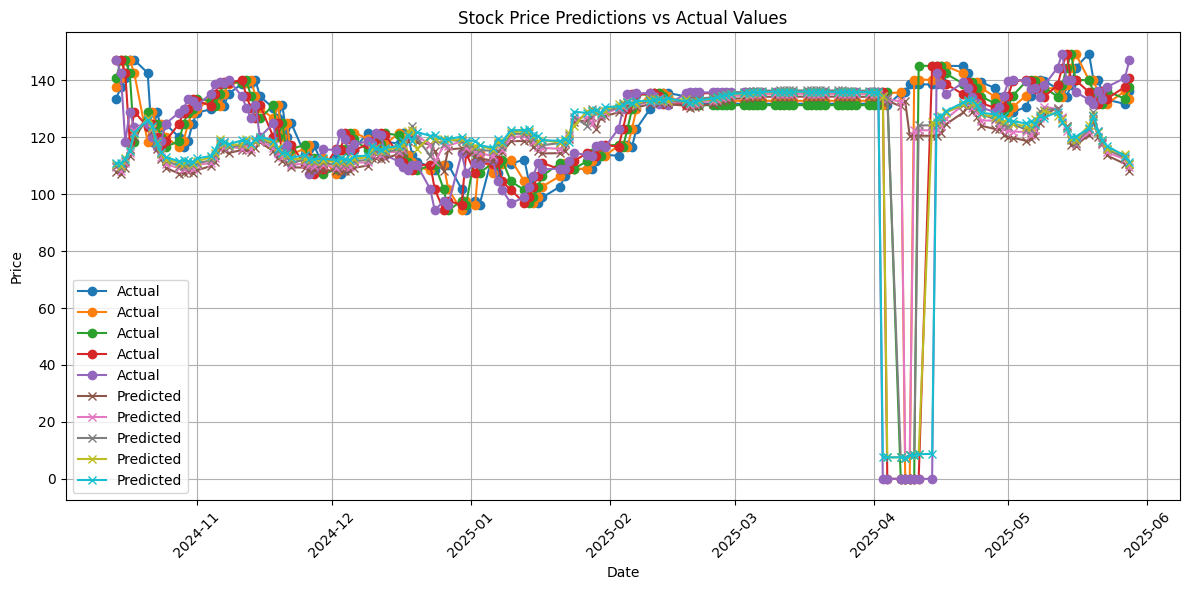


Training completed successfully!


In [10]:
def main():
    try:
        pl.seed_everything(42)

        # Initialize data preparation with more historical data
        ticker = "NVDA"
        data_prep = StockDataPreparation(ticker=ticker, lookback_days=60)
        stock_data = data_prep.get_stock_data(years=3)  # Increased to 3 years

        # Create datasets and dataloaders
        training_data, validation_data, train_dataloader, val_dataloader = create_datasets(
            stock_data,
            ticker=ticker,
            max_prediction_length=5,
            max_encoder_length=60,
            batch_size=64  # Increased batch size
        )

        # Initialize model
        model = StockTFTModel(training_data)

        # Setup callbacks with modified parameters
        callbacks = [
            EarlyStopping(
                monitor="val_loss",
                min_delta=1e-4,
                patience=10,  # Increased patience
                verbose=True,
                mode="min"
            ),
            LearningRateMonitor(logging_interval="epoch"),
            ModelCheckpoint(
                monitor="val_loss",
                dirpath="checkpoints",
                filename="tft-{epoch:02d}-{val_loss:.2f}",
                save_top_k=3,
                mode="min"
            )
        ]

        # Create checkpoint directory if it doesn't exist
        os.makedirs("checkpoints", exist_ok=True)

        # Setup trainer with modified parameters
        trainer = pl.Trainer(
            max_epochs=50,  # Increased epochs
            accelerator="cpu",
            devices=1,
            enable_checkpointing=True,
            gradient_clip_val=0.1,
            callbacks=callbacks,
            limit_train_batches=100,  # Increased training batches
            enable_progress_bar=True,
            logger=True
        )

        print("\nStarting model training...")
        trainer.fit(
            model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader
        )

        print("\nMaking predictions...")
        predictions = trainer.predict(model, val_dataloader)
        predictions = torch.cat(predictions)

        # Calculate metrics
        actuals = []
        for x, y in iter(val_dataloader):
            # Extract the first element of the tuple (actual values)
            if isinstance(y, (tuple, list)):
                y = y[0]
            actuals.append(y)
        actuals = torch.cat(actuals)

        # For metrics, use the median prediction (second quantile)
        median_predictions = predictions[:, :, 1]  # Using middle quantile (50th percentile)

        mae = MAE()
        smape = SMAPE()

        mae_value = mae(median_predictions, actuals)
        smape_value = smape(median_predictions, actuals)

        print("\nModel Performance:")
        print(f"Mean Absolute Error: {mae_value:.2f}")
        print(f"SMAPE: {smape_value:.2f}%")
        print(f"Number of training samples: {len(training_data)}")
        print(f"Number of validation samples: {len(validation_data)}")

        # Plot predictions vs actuals
        plot_predictions(
            median_predictions,
            actuals,
            stock_data['Date'][-len(predictions):]
        )

        print("\nTraining completed successfully!")

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        print("\nFull traceback:")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()